## Importing the Prepared Data

We load the preprocessed arrays produced by `data_preparation_data_org_nn.ipynb` (saved as `pickle_data/nn_data.pkl`).
This file contains `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `test_ids`.


In [1]:
# Load the preprocessed NN dataset (created by data_preparation_data_org_nn.ipynb)

import os
import pickle
import numpy as np

subdirectory = "pickle_data"
nn_data_path = os.path.join(subdirectory, "nn_data.pkl")

if not os.path.exists(nn_data_path):
    raise FileNotFoundError(
        f"Could not find {nn_data_path}. Run data_preparation_data_org_nn.ipynb first."
    )

with open(nn_data_path, "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
test_ids = data["test_ids"]
feature_names = data.get("feature_names", None)

# Ensure correct dtypes for TensorFlow
X_train = np.asarray(X_train, dtype=np.float32)
X_val   = np.asarray(X_val, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_val   = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

print("Loaded shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape)
print("test_ids:", test_ids.shape)

if feature_names is not None:
    print("Number of features:", len(feature_names))
    print("First 15 feature names:", feature_names[:15])

Loaded shapes:
X_train: (7493, 46) y_train: (7493, 1)
X_val:   (1841, 46) y_val:   (1841, 1)
X_test:  (1830, 46)
test_ids: (1830,)
Number of features: 46
First 15 feature names: ['id', 'Cloud Cover', 'Temperature', 'Wind Speed', 'Weather Code', 'Temperature_H', 'Wind Speed_H', 'Cloud Cover_H', 'Precipitation_H', 'doy', 'temp_anomaly', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_7']


## Defining the Neural Network

We define a simple feed-forward neural network for regression.
The input dimension is the number of engineered features in `X_train`.
You can tune layer sizes, dropout, and learning rate later.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_dim = X_train.shape[1]

model = Sequential([
    InputLayer(input_shape=(input_dim,)),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation="relu"),
    BatchNormalization(),

    Dense(1)  # regression output
])

model.summary()

c:\Users\Joalex\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\Joalex\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 54,145 (211.50 KB)

 Non-trainable params: 896 (3.50 KB)

## Compiling and Training the Model

We train on the training set and monitor validation loss.
Early stopping prevents overfitting and restores the best weights.


In [3]:
# MAPE is the Kaggle evaluation metric, but it's not a great training loss near 0.
# We train with MAE (stable) and *monitor* a safe MAPE metric with an epsilon.
import tensorflow as tf

def safe_mape(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    denom = tf.maximum(tf.abs(y_true), eps)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / denom)) * 100.0


In [4]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mae",                 # stable to train
    metrics=[safe_mape]         # aligns with Kaggle metric for reporting/monitoring
)

callbacks = [
    EarlyStopping(monitor="val_safe_mape", mode="min", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_safe_mape", mode="min", factor=0.5, patience=5, min_lr=1e-6),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 209.1664 - safe_mape: 99.8612 - val_loss: 195.8319 - val_safe_mape: 99.6660 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 208.6870 - safe_mape: 99.5045 - val_loss: 195.2449 - val_safe_mape: 99.1445 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 207.9818 - safe_mape: 98.9562 - val_loss: 194.4039 - val_safe_mape: 98.3972 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 207.0109 - safe_mape: 98.2233 - val_loss: 193.3844 - val_safe_mape: 97.4914 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 205.7554 - safe_mape: 97.2825 - val_loss: 191.9898 - val_safe_mape: 96.2523 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 204.2050 - safe_mape: 96.1306 - val_loss: 190.2023 - val_safe_mape: 94.6641 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

## Saving the Trained Model

After training, it's a good practice to save the model for future use.

In [5]:
# Save the trained model
model.save("nn_sales_model.keras")
print("Saved model to nn_sales_model.keras")

Saved model to nn_sales_model.keras


## Plotting Training History

Visualizing the training and validation loss can help us understand the model's performance over time.

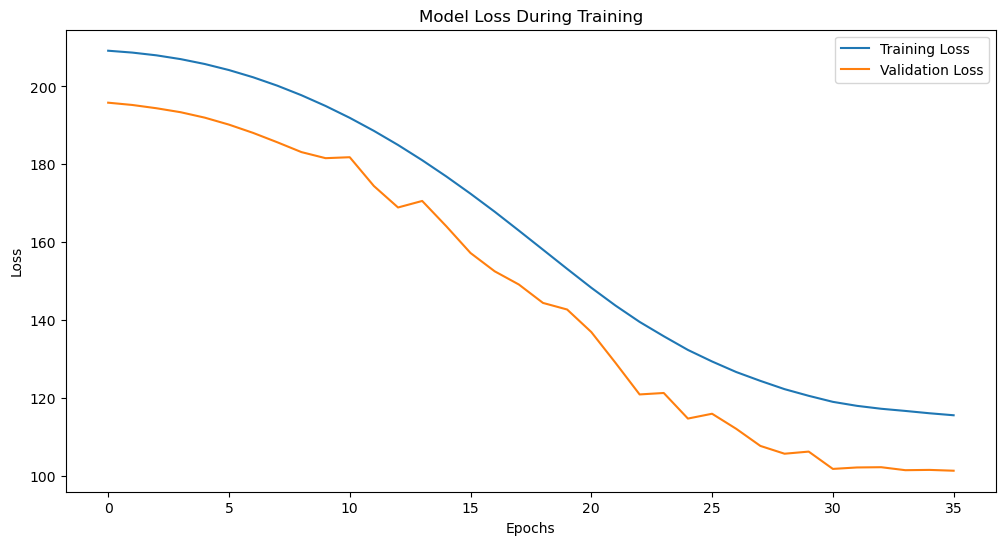

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Making Predictions and Evaluating the Model

We evaluate on train and validation (labels available). For Kaggle TEST, we only generate predictions for submission.


In [7]:
import numpy as np

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float).reshape(-1)
    y_pred = np.asarray(y_pred, dtype=float).reshape(-1)
    denom = np.clip(np.abs(y_true), eps, None)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

train_pred = model.predict(X_train, verbose=0)
val_pred   = model.predict(X_val, verbose=0)

print(f"MAPE on TRAIN: {mape(y_train, train_pred):.2f}%")
print(f"MAPE on VAL:   {mape(y_val, val_pred):.2f}%")

MAPE on TRAIN: 49.83%
MAPE on VAL:   47.73%


## Predicting TEST and Creating a Kaggle Submission

We generate predictions for the test set and save a CSV with columns `id` and `umsatz`.
Predictions are clipped to be non-negative.


In [8]:

import pandas as pd
import numpy as np

test_pred = model.predict(X_test, verbose=0).reshape(-1)
test_pred = np.clip(test_pred, 0.0, None)

submission = pd.DataFrame({
    "id": test_ids.astype(str),
    "umsatz": test_pred
}).sort_values("id")

out_path = os.path.join("data_prep", "submission_nn.csv")
os.makedirs("data_prep", exist_ok=True)
submission.to_csv(out_path, index=False)

print("Saved submission to:", out_path)
display(submission.head())


Saved submission to: data_prep\submission_nn.csv


,id,umsatz
0,1808011,87.360916
355,1808012,87.360916
710,1808013,87.360916
1065,1808014,87.360916
1419,1808015,87.360916


## Visualizing Predictions vs Actual Values

We plot a small slice of actual vs predicted values for the validation set.


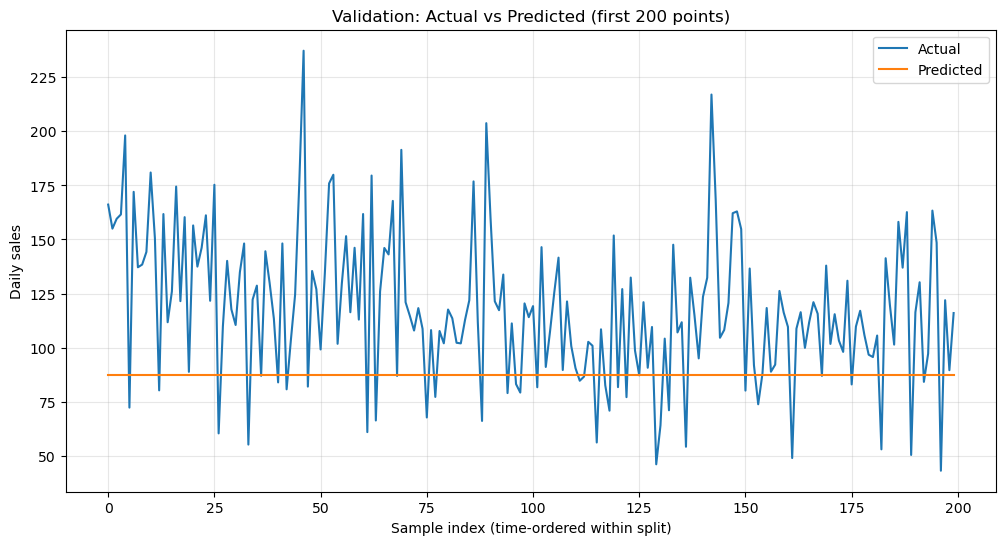

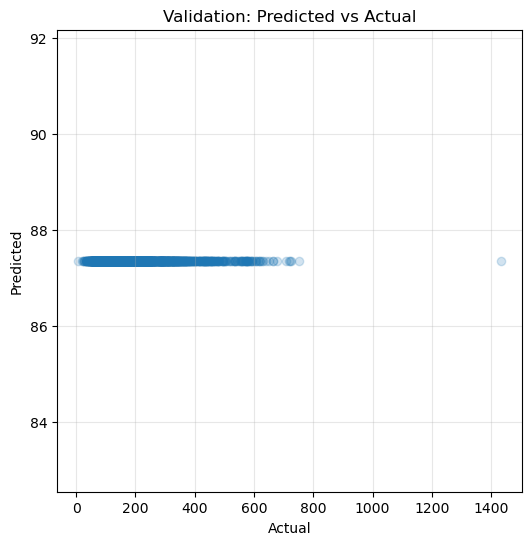

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

val_pred = model.predict(X_val, verbose=0).reshape(-1)
val_true = y_val.reshape(-1)

# Create a small dataframe for plotting
plot_df = pd.DataFrame({
    "actual": val_true,
    "predicted": val_pred
})

# Plot first N points (sorted by index/time)
N = 200
plt.figure(figsize=(12, 6))
plt.plot(plot_df["actual"].iloc[:N], label="Actual")
plt.plot(plot_df["predicted"].iloc[:N], label="Predicted")
plt.title("Validation: Actual vs Predicted (first 200 points)")
plt.xlabel("Sample index (time-ordered within split)")
plt.ylabel("Daily sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(plot_df["actual"], plot_df["predicted"], alpha=0.2)
plt.title("Validation: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.3)
plt.show()